# Modeling the flattening of the COVID-19 peaks

__Reference:__ _https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296_

## Intro

With the COVID-19 spreading rapidly around the world, many governments have taken the action - __socail distancing__. 
- The idea is to reduce person-to-person contact in order to make spreading the disease less likely.
- This helps to ensure that there are sufficient resources available for a sick population, which will help improve survival rates.

We walk through a SEIR epidemiological model and simulate it with Python.
- The SEIR model is a compartmental model for modeling how a disease spreads through a population. It’s an acronym for __Susceptible, Exposed, Infected, Recovered__.
- The first model is the basic SEIR __without social distancing__
- Then we add social distancing to show how the potential effectiveness of these strategies.
- When they reach the R state, they’re no longer able to be infected, depending on your interpretation, they either survived the disease and are now immune or succumbed to the illness and are out of the population.

In [58]:
# Packages for importing
import numpy as np
import matplotlib.pyplot as plt

# Automatically plots
%matplotlib inline
# For Mac Retina Plots
%config InlineBackend.figure_format ='retina'

_The SEIR Model_

#### <center> $\dot S = - \beta S I$ </center>
_The change in people susceptible to the disease and is moderated by the number of infected people and their contact with the infected._

#### <center> $\dot E = \beta S I - \alpha E$ </center>
_The people who have been exposed to the disease grows based on the contact rate and decreases based on the incubation period whereby people then become infected._

#### <center> $\dot I = \alpha E - \gamma I$ </center>
_The change in infected people based on the exposed population and the incubation period. It decreases based on the infectious period, so the higher γ is, the more quickly people die/recover and move on to the final stage_

#### <center> $\dot R = \gamma I$ </center>
_Final stage_

#### <center> $N = S + E + I + R$ </center>
_a fixed population_

_where_ 
- $\alpha$: _is the inverse of the incubation period_ 
- $\beta$: _is the average contact rate in the population_
- $\gamma$: _is the inverse of the mean infectious period_

In [72]:
def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:] :
        next_S = S[-1] - (beta * S[-1] * I[-1]) * dt
        next_E = E[-1] + (beta * S[-1] * I[-1] - alpha * E[-1]) * dt
        next_I = I[-1] + (alpha * E[-1] - gamma * I[-1]) * dt
        next_R = R[-1] + (gamma * I[-1]) * dt
        S.append(next_S); E.append(next_E); I.append(next_I); R.append(next_R)
        # .T for transpose, so that output would be series of [S[i], E[i], I[i], R[i]]
    return np.stack([S, E, I, R]).T

For any system of ODE’s, we need to provide initial values. 

We’ll use normalized population values for our S_0, E_0, etc. 

So if we assume we have 10k people in our population, and we begin with one exposed person and the remaining 9,999 susceptible, we have:

In [73]:
# Define parameters
t_max = 100
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2; beta = 1.75; gamma = 0.5
params = alpha, beta, gamma

# Run simulation
results = base_seir_model(init_vals, params, t)

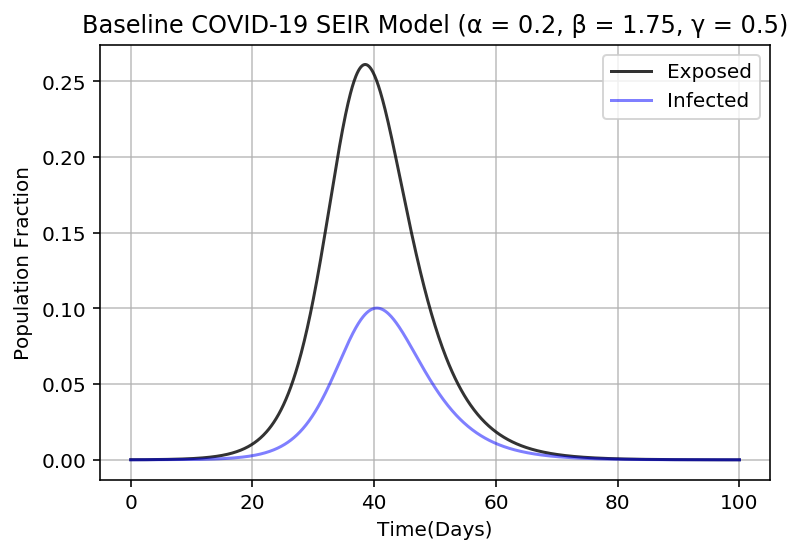

In [76]:
# Only interested in the flattening effect of social distancing.
# Just plot the E and I terms of simulation.

plt.plot(t, results[:, 1], label = "Exposed", color = "black", alpha = 0.8)
plt.plot(t, results[:, 2], label = "Infected", color = "blue", alpha = 0.5)
plt.xlabel("Time(Days)")
plt.ylabel("Population Fraction")
plt.grid(alpha = 0.8)
plt.title("Baseline COVID-19 SEIR Model (\u03B1 = 0.2, \u03B2 = 1.75, \u03B3 = 0.5)")
plt.legend()

__Social distancing__ includes avoiding large gatherings, physical contact, and other efforts to mitigate the spread of infectious disease. According to our model, the term this is going to __impact is our contact rate, β.__

Let’s introduce a new value, ρ, to capture our social distancing effect. This is going to be a constant term between 0 – 1, where 0 indicates everyone is locked down and quarantined while 1 is equivalent to our base case above. 

In [77]:
def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho * beta * S[-1] * I[-1]) * dt
        next_E = E[-1] + (rho * beta * S[-1] * I[-1] - alpha * E[-1]) * dt
        next_I = I[-1] + (alpha * E[-1] - gamma * I[-1]) * dt
        next_R = R[-1] + (gamma * I[-1]) * dt
        S.append(next_S); E.append(next_E); I.append(next_I); R.append(next_R)
    return np.stack([S, E, I, R]).T

In [78]:
# Define parameters
t_max = 200; dt = .1; t = np.linspace(0, t_max, int(t_max/dt) + 1)
N = 10000; init_vals = 1 - 1/N, 1/N, 0, 0
alpha = 0.2; beta = 1.75; gamma = 0.5


# Run simulation
params = alpha, beta, gamma, 1
results_1 = seir_model_with_soc_dist(init_vals, params, t)
params = alpha, beta, gamma, .8
results_2 = seir_model_with_soc_dist(init_vals, params, t)
params = alpha, beta, gamma, .5
results_3 = seir_model_with_soc_dist(init_vals, params, t)

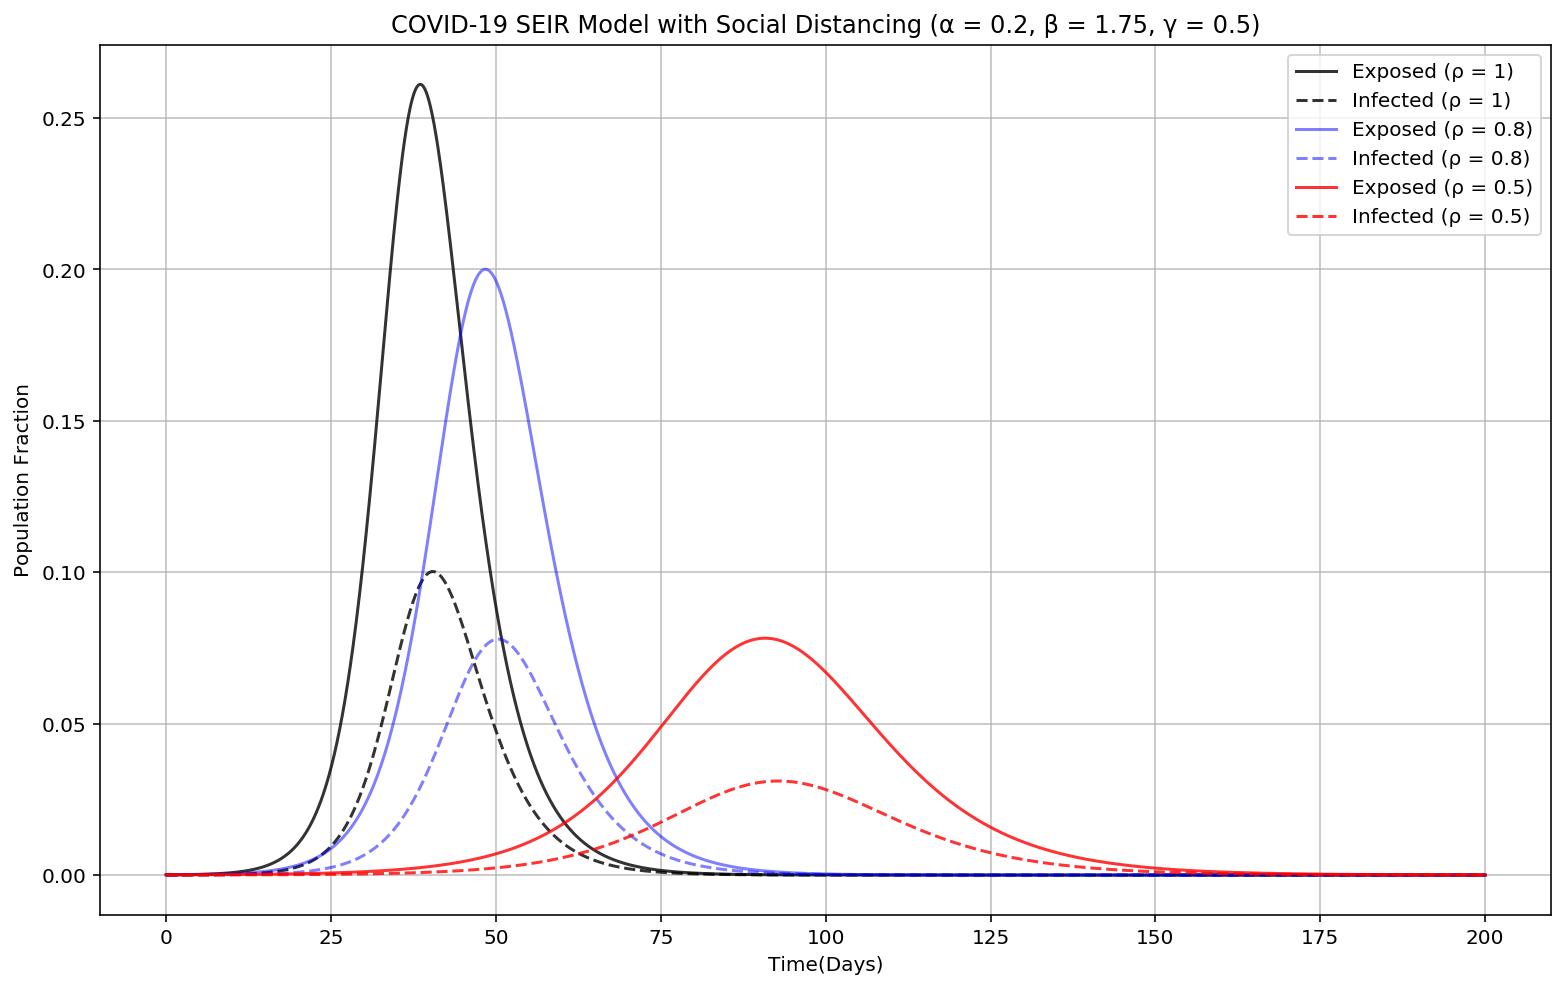

In [79]:
plt.figure(figsize=(13,8))

# Without Social Distancing
plt.plot(t, results_1[:, 1], label = "Exposed (\u03C1 = 1)", color = "black", alpha = 0.8)
plt.plot(t, results_1[:, 2], label = "Infected (\u03C1 = 1)", color = "black", alpha = 0.8, linestyle = 'dashed')
# With Mild Social Distancing (rho = 0.8)
plt.plot(t, results_2[:, 1], label = "Exposed (\u03C1 = 0.8)", color = "blue", alpha = 0.5)
plt.plot(t, results_2[:, 2], label = "Infected (\u03C1 = 0.8)", color = "blue", alpha = 0.5, linestyle = 'dashed')
# With Strong Social Distancing (rho = 0.5)
plt.plot(t, results_3[:, 1], label = "Exposed (\u03C1 = 0.5)", color = "red", alpha = 0.8)
plt.plot(t, results_3[:, 2], label = "Infected (\u03C1 = 0.5)", color = "red", alpha = 0.8, linestyle = 'dashed')



plt.xlabel("Time(Days)")
plt.ylabel("Population Fraction")
plt.grid(alpha = 0.8)
plt.title("COVID-19 SEIR Model with Social Distancing (\u03B1 = 0.2, \u03B2 = 1.75, \u03B3 = 0.5)")
plt.legend()

## Conclusion:

Finally, the result showed that with socail distancing, we may __reduce the peak and increase the lag in the effect on the total population.__